## **Facial Recoginiton System** (End term Assignment)

### 1. Importing Libraries and Setup

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
os.chdir("D:/vu/academics/terms/term_11/AI_Decision_Sciences")

### 2. Reading Images 

In [3]:
# the main folder where all the photos are stored
data_dir = 'photos_named_data' 

In [4]:
images=[]
labels=[]

In [5]:
# loading the images of each individual person, with a respective label assigned to each

for label, subfolder in enumerate(os.listdir(data_dir)):
    subfolder_path = os.path.join(data_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)  
                img = cv2.resize(img, (128,128))
                img = img.astype(np.float32) / 255.0
                images.append(img)
                labels.append(label)

In [6]:
# Converting the images and labels into numpy arrays so that the sequential model can take them in as a input
images = np.array(images)
labels = np.array(labels)

In [7]:
# print(labels)

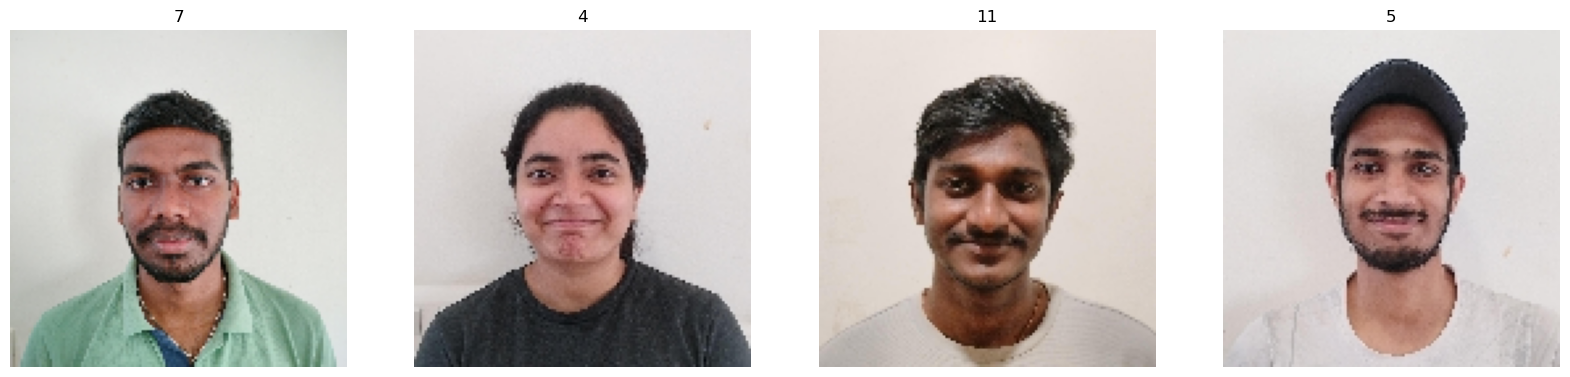

In [8]:
## Plotting 4 random images from the image data that was loaded and compressed to a pixel size of 128*128

import random

# Create a list of random indices to select random images
random_indices = random.sample(range(len(images)), 4)

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img_idx in enumerate(random_indices):
    img = images[img_idx]
    label = labels[img_idx]
    # Convert BGR to RGB color space
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax[idx].imshow(img_rgb)  
    ax[idx].title.set_text(label)
    ax[idx].axis('off')

plt.show()


### 3. Saving and Splitting the Data

In [9]:
np.savez('insofe2020_dataset.npz', images=images, labels=labels)

**Saving the data into np.savez() format to:**
 
* *The compression used in NPZ format reduces file size, making it efficient for large datasets and saving disk space.*
* *The widespread usage of NPZ in the NumPy ecosystem ensures data portability, allowing easy sharing and compatibility across different machines and environments.*

In [10]:
from sklearn.model_selection import train_test_split

# Load the dataset
data = np.load('insofe2020_dataset.npz')
images = data['images']
labels = data['labels']

# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.20, random_state=42)

In [11]:
x_train = train_images
x_test = test_images

In [12]:
# Checking the shape of the dataset
print(x_train.shape, x_test.shape)

(559, 128, 128, 3) (140, 128, 128, 3)


In [13]:
# Reshaping the data in order to give input to the autoencoder model
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

#Checking the shape again
print (x_train.shape)
print (x_test.shape)

(559, 49152)
(140, 49152)


### 4. Build Model

#### 4.1 **Autoencoder Model**

In [14]:
# Importing required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [15]:
# Defining the function to create the autoencoder model
def create_model(encoding_dim, hidden_units):
    input_img = Input(shape=(x_train.shape[1],))
    encoded = Dense(hidden_units[0], activation='relu')(input_img)
    
    # Adding additional hidden layers
    for units in hidden_units[1:]:
        encoded = Dense(units, activation='relu')(encoded)
    
    decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

###### **Using a GridSearch CV to find the best model parameters and layer combinations.**

In [16]:
# Creating a KerasRegressor based on the autoencoder model
model = KerasRegressor(build_fn=create_model, verbose=0)

C:\Users\Dhwani Bhandari\AppData\Local\Temp\ipykernel_6036\3011939887.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [17]:
#creating diffrent models with different sizes of encoding layer and hidden layer combinations
param_grid = {
    'encoding_dim': [32, 64],
    'hidden_units': [[0], [128, 128]]
}

In [18]:
# Performing grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(x_train, x_train,
               epochs=10,
               shuffle=True,
               validation_data=(x_test, x_test))

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022A25A16A30>,
             param_grid={'encoding_dim': [32, 64],
                         'hidden_units': [[0], [128, 128]]})

In [19]:
# Printing the results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

Best Parameters: {'encoding_dim': 64, 'hidden_units': [128, 128]}
Best Score (MSE): 0.010271977633237839


###### **The best autoencoder model is the one where the model has an input layer of 49152 neurons, hidden layer 1 of 128 neurons, encoding_layer of 32 neurons, hidden layer 2 of 128 neurons and the decoding_layer with 49152 neurons**

In [20]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_.model

#### 4.1.1 Evaluate the model

In [21]:
# Evaluate the best model on the train and test set
train_loss = best_model.evaluate(x_train, x_train)
print("Training Loss (MSE):", train_loss)

test_loss = best_model.evaluate(x_test, x_test)
print("Test Loss (MSE):", test_loss)

18/18 [==============================] - 1s 42ms/step - loss: 0.0086
Training Loss (MSE): 0.008627294562757015
5/5 [==============================] - 0s 35ms/step - loss: 0.0090
Test Loss (MSE): 0.00901270192116499


#### 4.1.2 Train the model and plot performance

Epoch 1/50
3/3 [==============================] - 4s 1s/step - loss: 0.0086 - val_loss: 0.0089
Epoch 2/50
3/3 [==============================] - 2s 542ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 3/50
3/3 [==============================] - 2s 564ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 4/50
3/3 [==============================] - 2s 491ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 5/50
3/3 [==============================] - 2s 514ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 6/50
3/3 [==============================] - 2s 564ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 7/50
3/3 [==============================] - 2s 538ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 8/50
3/3 [==============================] - 2s 537ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 9/50
3/3 [==============================] - 2s 563ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 10/50
3/3 [==============================] - 2s 719ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 11/50
3/3 [=====

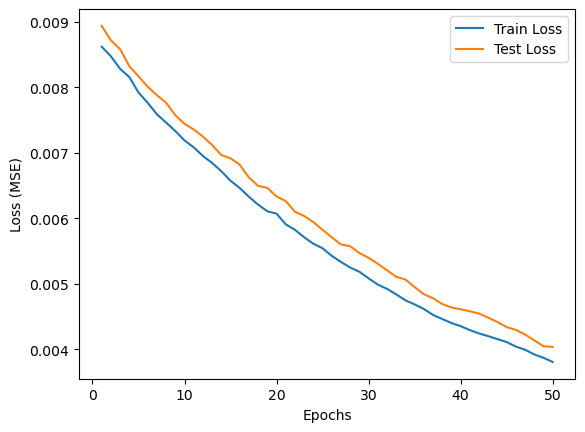

In [22]:
import matplotlib.pyplot as plt

# Training the best model and collect loss values
history = best_model.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Creating a plot of train loss and test loss over epochs
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

###### **The loss decreases with each epoch and it can be seen the train and test losses after going through 50 epochs are pretty stable.**

#### 4.1.3 Predict

In [23]:
# Getting the decoded representations
decoded_imgs = best_model.predict(x_test)

5/5 [==============================] - 1s 25ms/step


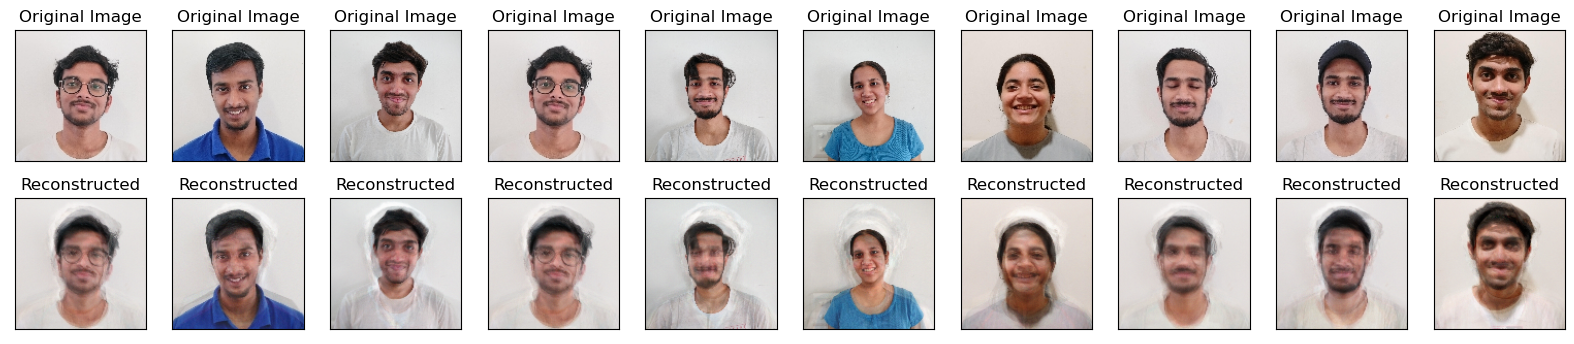

In [24]:
n = 10  # how many images will be displayed
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img =x_test[i].reshape(128,128,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original Image')
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    img =decoded_imgs[i].reshape(128,128,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstructed')

plt.show()

##### **Plot of the reconstructed images generated by the autoencoder model in comparison to the original images.**

#### 4.2 **Classification Model**

In [25]:
from tensorflow.keras import layers, models
# Create a new model for classification
classification_encoder = models.Model(best_model.input, best_model.layers[3].output) 

# Not letting the weights of the autoencoder model be updated, saves time, computational cost 
classification_encoder.trainable = False

classification_model = models.Sequential()
classification_model.add(classification_encoder)
classification_model.add(layers.Flatten())
classification_model.add(layers.Dense(12, activation='softmax'))  # Assuming 12 different people

# Compiling the model
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### 4.2.1 Train the model

In [ ]:
# Train the classification model
history = classification_model.fit(x_train, train_labels, epochs=35, batch_size=32,validation_data = (x_test, test_labels))

prediction = classification_model.predict(x_test)

prediction.shape

Epoch 1/35
18/18 [==============================] - 2s 87ms/step - loss: 36.6737 - accuracy: 0.1342 - val_loss: 17.8436 - val_accuracy: 0.2571
Epoch 2/35
18/18 [==============================] - 1s 64ms/step - loss: 7.9481 - accuracy: 0.3578 - val_loss: 5.6333 - val_accuracy: 0.5143
Epoch 3/35
18/18 [==============================] - 1s 80ms/step - loss: 3.1459 - accuracy: 0.5796 - val_loss: 3.7305 - val_accuracy: 0.4643
Epoch 4/35
18/18 [==============================] - 1s 78ms/step - loss: 1.6073 - accuracy: 0.6869 - val_loss: 1.8706 - val_accuracy: 0.7071
Epoch 5/35
18/18 [==============================] - 1s 70ms/step - loss: 1.2358 - accuracy: 0.7996 - val_loss: 0.7187 - val_accuracy: 0.7929
Epoch 6/35
18/18 [==============================] - 1s 68ms/step - loss: 0.7897 - accuracy: 0.8283 - val_loss: 0.4566 - val_accuracy: 0.8571
Epoch 7/35
18/18 [==============================] - 1s 67ms/step - loss: 0.5591 - accuracy: 0.8515 - val_loss: 0.9903 - val_accuracy: 0.8571
Epoch 8/35


In [ ]:
# Save the model
classification_model.save('model.h5')

#### 4.2.2 Plot the performance

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
pyplot.legend()
pyplot.show()

###### **The loss decreases with each epoch and it can be seen the train and test losses become almost equal early on itself, indicating a perfect fit.**

### 4.2.3 Predictions

In [ ]:
# creating a dictionary to map the classes to thier true value
names = {0 : "Abhay", 1:"Atif",2:"Bhanu",3:"Dhwani",4:"Hashika",5:"Mustafa",6:"Prasad",7:"Rahul",8:"Salman",9:"Shivansh",10:"Swaijit",11:"Yugandhar"}

In [ ]:
correct = 0
num_images = 12
num_images_per_row = 4

fig, axs = plt.subplots(num_images // num_images_per_row, num_images_per_row, figsize=(12, 9))
fig.subplots_adjust(hspace=0.4)

for i in range(num_images):
    if np.argmax(prediction[i]) == test_labels[i]:
        correct += 1
    img = x_test[i].reshape(128, 128, 3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = axs[i // num_images_per_row, i % num_images_per_row]
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Actual: {}\nPredicted: {}".format(names[test_labels[i]], names[np.argmax(prediction[i])]))

plt.show()

print("Accuracy: ", (correct / float(num_images)))


###### **Plotting the images and what they were predicted and what was the actual label, all the images are predicted accurately using the burst images itself.**

### 5. Conclusion

* **Since the dataset contained burst images and only 2, 3 variations per person, if the model were to be applied on real world data it would not perform as well.**

* **Techniques like data augmentation used to increase the size of the training set, and getting more train data by getting the images of each person in different angles would be helpful.**

* **Preprocessing steps where we use a face detection model can be used. The output of the face detection model would be used to build the other models, to improve   predictions on real world data.**

### 6. Testing the model on real world data

In [ ]:
# # Define the path to the test image folder

# import tensorflow as tf

# test_folder_path = 'test'

# # Load the trained model
# model = tf.keras.models.load_model('model.h5')

# # Define image size 
# image_size = (128, 128)

# # Load and preprocess test images
# test_images = []
# true_labels = []
# for filename in os.listdir(test_folder_path):
#     if filename.endswith('.jpg') or filename.endswith('.jpeg'):
#         image_path = os.path.join(test_folder_path, filename)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, image_size)
#         image = image.astype(np.float32) / 255.0
#         # Add any necessary preprocessing steps here
#         test_images.append(image)
#         true_label = os.path.splitext(filename)[0]  # Extract true label from the filename without extension
#         true_labels.append(true_label)

# # Convert test images to NumPy array
# test_images = np.array(test_images)

# test_images = test_images.reshape(test_images.shape[0], np.prod(test_images.shape[1:]))

# # Make predictions on the test images
# predictions = model.predict(test_images)

# # Get the predicted labels
# predicted_labels = np.argmax(predictions, axis=1)

# predicted_names = [names[label] for label in predicted_labels]

# # Plot the predictions and compare with true labels
# num_images = len(test_images)
# num_rows = int(np.ceil(num_images / 4))
# fig, axs = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
# fig.subplots_adjust(hspace=0.4)

# for i in range(num_images):
#     ax = axs[i // 4, i % 4]
#     img = test_images[i].reshape(image_size + (3,))
#     ax.imshow(img)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title("True: {}\nPred: {}".format(true_labels[i], predicted_names[i]))  # Modify this line based on label format
#     if i == num_images - 1:
#         break

# plt.show()

# # Calculate accuracy
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(true_labels,predicted_names)
# print("Accuracy:", accuracy)